# 3PCF Demo

In this notebook, we will demonstrate how to use the `dust-3pcf` code and explain how the calculations work.

In [ ]:
import numpy as np
from subprocess import call
import astropy.io.fits as pyf
import matplotlib.pyplot as plt

## Step 1: Make the kernels

The first step is to make the spherical harmonic kernels tailored to the size of our data cubes and our choice of bins. We will be running on a 256<sup>3</sup> data cube, and we will choose to use 4 radial bins linearly spaced between 1 and 128 pixels. (Keeping the number of bins small will allow the necessary files to fit on disk and memory in Google Colab.) These kernels can be reused for any input data of our chosen size (256<sup>3</sup> in this case), so we give them the identifier `demo` to allow them to be retrieved later. 

The code in Step 1 is equivalent to running

```python ylm_kernel_and_ft.py demo 256 1 128 4 LIN```

on the command line.

In [ ]:
save_name = 'demo'
eps = 1e-15
ell_max = 5
nbins = 4
#don't set it to zero, because spherical harmonics are ill-defined at the origin
bin_min = 1-1e-5
#radius from the origin.
bin_max = 128+1e-5

switch = {
	'LIN' : np.linspace(bin_min, bin_max, nbins+1),
	'INV' : 1./np.linspace(1./bin_min, 1./bin_max, nbins+1),
	'LOG' : np.exp(np.linspace(np.log(bin_min), np.log(bin_max), nbins+1))
}
bin_edges = switch['LIN']
ld_one_d = 256

We create three 256<sup>3</sup> arrays containing $(x,y,z)$ positions, with the origin being in the middle. These and arrays containing $r$ and $r^2$ will be used to sort voxels into bins and calculate the spherical harmonics.

In [ ]:
x = np.linspace(-ld_one_d/2, ld_one_d/2-1 , ld_one_d)
xsq = x*x
m_center = np.where(x==0)[0][0]
X, Y, Z = np.meshgrid(x, x, x, indexing='ij')
X = -X
Y = -Y
Z = -Z
Xsq, Ysq, Zsq = np.meshgrid(xsq, xsq, xsq,indexing='ij')
#PRECOMPUTE POWERS OF ARRAYS AND COMBINATIONS (e.g. x - iy).
Rsq = Xsq+Ysq+Zsq
R = np.sqrt(Rsq)
del Rsq
zero_ind = np.where(R==0)
R[zero_ind] = eps
X[zero_ind] = eps
Y[zero_ind] = eps
Z[zero_ind] = eps

The above code also calculates how many voxels fall into each of the radial bins we defined. While the number of voxels in a bin is approximately $4 \pi r^2 \Delta r$, it will be useful to know the exact number of voxels when normalizing the 3PCF. We show a slice of the 256<sup>3</sup> cube and color voxels by the bin they fall in. Note that the data cube will be treated as periodic, so we do not want bins that extend farther than half the box width.

In [ ]:
boundsandnumber = np.zeros((2, nbins+1))
boundsandnumber[0,:] = bin_edges
for i in range(nbins):
    boundsandnumber[1,i] = np.sum(np.logical_and(R >= bin_edges[i],
                                               R < bin_edges[i+1]))
np.save('bin_bounds_and_pixel_number_'+save_name+'.npy',boundsandnumber)

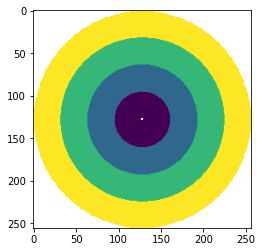

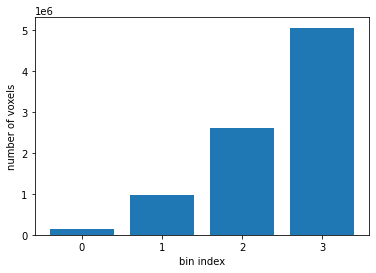

In [ ]:
whichbin = np.full_like(R, float('nan'))
for i in range(nbins):
    mask = np.logical_and(R >= bin_edges[i], R < bin_edges[i+1])
    whichbin[mask] = i
plt.imshow(whichbin[ld_one_d//2,:,:])
plt.show()
plt.bar(range(nbins), boundsandnumber[1,0:nbins])
plt.xticks(range(nbins))
plt.xlabel('bin index')
plt.ylabel('number of voxels')
plt.show()

We calculate and save the spherical harmonics computed on the 256<sup>3</sup> cube. Intermediate results are saved to disk to keep memory requirements low enough to run on a laptop.

In [ ]:
def ylm_save(ylm, ell, m):
    np.save('ylm_'+save_name+'_'+str(ell)+'_'+str(m)+'.npy',ylm)#zs: to work on my laptop.
    del ylm

def ylm_transform_save(ylm_on_shell, ell, m, i):
    FT = np.fft.fftn(np.fft.fftshift(ylm_on_shell))
    np.save('YLMtilde_'+save_name+'_'+str(ell)+'_'+str(m)+'_bin_'+str(i)+'.npy',FT)
    del FT

In [ ]:
#COMPUTE YLMS SEQUENTIALLY AND SAVE.
#ell, m = 0,0
y00 =.5*(1./np.pi)**.5*np.ones((ld_one_d,ld_one_d,ld_one_d))
ylm_save(y00, 0, 0)
del y00

#ell, m = 1, -1
xdivr = X/R
del X
ydivr = Y/R#we'll need these as individuals later anyway.
del Y
xmiydivr = xdivr - 1j*ydivr
y1m1 = .5*np.sqrt(3./(2.*np.pi))*xmiydivr
ylm_save(y1m1, 1, 1)
del y1m1

#ell, m = 1, 0
zdivr = Z/R
del Z
y10 = .5*np.sqrt(3./np.pi)*zdivr
ylm_save(y10, 1, 0)
del y10

#ell, m = 2, -2
xmiydivrsq = xmiydivr*xmiydivr
y2m2 = .25*np.sqrt(15./(2.*np.pi))*xmiydivrsq
ylm_save(y2m2, 2, 2)
del y2m2

#ell, m = 2, -1
y2m1 = .5*np.sqrt(15./(2.*np.pi))*xmiydivr*zdivr
ylm_save(y2m1, 2, 1)
del y2m1

#ell, m = 2, 0
xdivrsq = xdivr*xdivr
ydivrsq = ydivr*ydivr
zdivrsq = zdivr*zdivr
y20 = .25*np.sqrt(5./np.pi)*(2.*zdivrsq-xdivrsq-ydivrsq)
ylm_save(y20, 2, 0)
del y20

#ell, m = 3, -3
xmiydivrcu = xmiydivr*xmiydivrsq
y3m3 = .125*np.sqrt(35./np.pi)*xmiydivrcu
ylm_save(y3m3, 3, 3)
del y3m3

#ell, m = 3, -2
y3m2 = .25*np.sqrt(105./(2.*np.pi))*xmiydivrsq*zdivr
ylm_save(y3m2, 3, 2)
del y3m2

#ell, m = 3, -1
y3m1 = .125*np.sqrt(21./np.pi)*(xmiydivr*(4.*zdivrsq-xdivrsq-ydivrsq))
ylm_save(y3m1, 3, 1)
del y3m1

#ell, m = 3, 0
y30 = .25*np.sqrt(7./np.pi)*(zdivr*(2.*zdivrsq-3.*xdivrsq-3.*ydivrsq))
ylm_save(y30, 3, 0)
del y30

#ell, m = 4, -4
xmiydivrft = xmiydivr*xmiydivrcu
y4m4 = .1875*np.sqrt(35./(2.*np.pi))*xmiydivrft
ylm_save(y4m4, 4, 4)
del y4m4

#ell, m = 4, -3
y4m3 = .375*np.sqrt(35./np.pi)*xmiydivrcu*zdivr
ylm_save(y4m3, 4, 3)
del y4m3

#ell, m = 4, -2
y4m2 = .375*np.sqrt(5./(2.*np.pi))*xmiydivrsq*(7.*zdivrsq-1)
ylm_save(y4m2, 4, 2)
del y4m2

#ell, m = 4, -1
y4m1 = .375*np.sqrt(5./np.pi)*xmiydivr*zdivr*(7.*zdivrsq-3.)
ylm_save(y4m1, 4, 1)
del y4m1

#ell, m = 4, 0
zdivrft = zdivrsq*zdivrsq
y40 = .1875*np.sqrt(1./np.pi)*(35.*zdivrft-30.*zdivrsq+3.)
ylm_save(y40, 4, 0)
del y40

#ell, m = 5, -5
xmiydivrfi = xmiydivr*xmiydivrft
y5m5 = (3./32.)*np.sqrt(77./np.pi)*xmiydivrfi
ylm_save(y5m5, 5, 5)
del y5m5

#ell, m = 5, -4
y5m4 = (3./16.)*np.sqrt(385./(2.*np.pi))*xmiydivrft*zdivr
ylm_save(y5m4, 5, 4)
del y5m4

#ell, m = 5, -3
y5m3 = (1./32.)*np.sqrt(385./np.pi)*xmiydivrcu*(9.*zdivrsq-1.)
ylm_save(y5m3, 5, 3)
del y5m3

#ell, m = 5, -2
zdivrcu = zdivr*zdivrsq
y5m2 = (1./8.)*np.sqrt(1155./(2.*np.pi))*xmiydivrsq*(3.*zdivrcu-zdivr)
ylm_save(y5m2, 5, 2)
del y5m2

#ell, m = 5, -1
y5m1 = (1./16.)*np.sqrt(165./(2.*np.pi))*xmiydivr*(21.*zdivrft-14.*zdivrsq+1.)
ylm_save(y5m1, 5, 1)
del y5m1

#ell, m = 5, 0
zdivrfi = zdivr*zdivrft
y50 = (1./16.)*np.sqrt(11./np.pi)*(63.*zdivrfi-70.*zdivrcu+15.*zdivr)
ylm_save(y50, 5, 0)
del y50

We show slices of the real part of the spherical harmonics below. Note that the spherical harmonics are only functions of angle, not of radius from the origin.

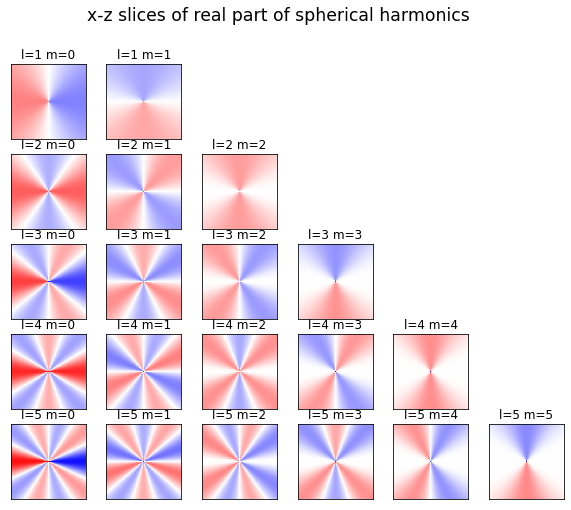

In [ ]:
plt.figure(figsize=(10,8))
for ell in range(1, ell_max+1):
    for m in range(0, ell+1):
        plt.subplot(ell_max, ell_max+1, (ell-1)*(ell_max+1)+m+1)
        ylm = np.load('ylm_'+save_name+'_'+str(ell)+'_'+str(m)+'.npy')
        plt.imshow(ylm[:,ld_one_d//2,:].real, interpolation='none', vmin=-1, vmax=1, cmap='bwr', origin='lower')
        plt.xticks([])
        plt.yticks([])
        plt.title('l='+str(ell)+' m='+str(m))
plt.suptitle('x-z slices of real part of spherical harmonics', fontsize='xx-large')
plt.show()

We want to convolve the input data with these spherical harmonics restricted to each of our radial bins, $Y_{\ell m}(\hat{r}) \Theta(r, S)$, where the radial bins are indexed by $S$. The binned spherical harmonics for $(\ell, m)=(1,0)$ are shown in the figure below.

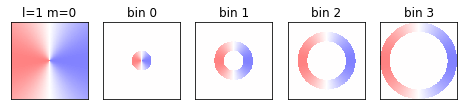

In [ ]:
ell = 1
m = 0
ylm = np.load('ylm_'+save_name+'_'+str(ell)+'_'+str(m)+'.npy')
plt.figure(figsize=(8,2))
plt.subplot(1,nbins+1,1)
plt.imshow(ylm[:,ld_one_d//2,:].real, interpolation='none', vmin=-1, vmax=1, cmap='bwr')
plt.xticks([])
plt.yticks([])
plt.title('l='+str(ell)+' m='+str(m))
for i in range(nbins):
    rib = np.where((R >= bin_edges[i]) & (R < bin_edges[i+1]))
    ylm_on_shell = np.zeros((ld_one_d, ld_one_d, ld_one_d)) + 0j
    ylm_on_shell[rib] = ylm[rib]
    plt.subplot(1,nbins+1,i+2)
    plt.imshow(ylm_on_shell[:,ld_one_d//2,:].real, interpolation='none', vmin=-1, vmax=1, cmap='bwr')
    plt.xticks([])
    plt.yticks([])
    plt.title('bin '+str(i))
plt.show()

This code ends by taking every combination of spherical harmonic and bin index, calculating the spherical harmonic restricted to that bin and then saving its Fourier transform for easy convolution later.

In [ ]:
for ell in range(0, ell_max+1):
    for m in range(0, ell+1):
        print("ell, m = ", ell, m)
        #do one ylm at a time to save lots of accessing memory
        ylm = np.load('ylm_'+save_name+'_'+str(ell)+'_'+str(m)+'.npy') 
        for i in range(nbins):
            print("bin i = ", i)
            #where is radius in bin?
            rib = np.where((R >= bin_edges[i]) & (R < bin_edges[i+1]))
            ylm_on_shell = np.zeros((ld_one_d, ld_one_d, ld_one_d)) + 0j
            ylm_on_shell[rib] = ylm[rib]
            del rib
            ylm_transform_save(ylm_on_shell, ell, m, i)
            del ylm_on_shell
        if 'ylm' in globals():
            del ylm
        file_to_rm = 'ylm_'+save_name+'_'+str(ell)+'_'+str(m)+'.npy'
        call(["rm", file_to_rm])

ell, m =  0 0
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  1 0
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  1 1
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  2 0
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  2 1
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  2 2
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  3 0
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  3 1
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  3 2
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  3 3
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  4 0
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  4 1
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  4 2
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  4 3
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  4 4
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  5 0
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  5 1
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  5 2


## Step 2: Convolve kernels with data

To calculate the 3PCF, we need the kernels that correspond to the size of the input data cubes and our choice of binning. Remember that these kernels can be reused for any input of the same size. We then convolve the data with these kernels and combine the convolutions to yield the 3PCF coefficients $\zeta_{\ell}(S_1,S_2)$.

The code in step 2 is equivalent to running

```python kernel_convolver.py dens_t800 demo 0```

on the command line with `dens_t800.fits.gz` in the `data/` directory.

In [ ]:
save_name = 'dens_t800'
kernel_name = 'demo'
file = save_name+'.fits.gz'

bin_bounds = np.load('bin_bounds_and_pixel_number_'+kernel_name+'.npy')
nbins = bin_bounds.shape[1] - 1

For our data cube, let's use a simulation from the [Catalogue for Astrophysical Turbulence Simulations
](https://www.mhdturbulence.com/) (Burkhart et al., submitted). We also confirm that our `demo` kernels for each $(\ell,m)$ and bin are on disk. 

In [ ]:
!wget https://users.flatironinstitute.org/~bburkhart/data/CATS/MHD/256/b.1p.32/t_800/dens_t800.fits.gz
!ls

--2021-06-04 20:32:47--  https://users.flatironinstitute.org/~bburkhart/data/CATS/MHD/256/b.1p.32/t_800/dens_t800.fits.gz
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 104.26.6.230, 172.67.75.60, 104.26.7.230, ...
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|104.26.6.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58559678 (56M) [application/octet-stream]
Saving to: ‘dens_t800.fits.gz’

dens_t800.fits.gz   100%[===================>]  55.85M  75.4MB/s    in 0.7s    

2021-06-04 20:32:48 (75.4 MB/s) - ‘dens_t800.fits.gz’ saved [58559678/58559678]

bin_bounds_and_pixel_number_demo.npy  YLMtilde_demo_4_0_bin_1.npy
dens_t800.fits.gz		      YLMtilde_demo_4_0_bin_2.npy
sample_data			      YLMtilde_demo_4_0_bin_3.npy
YLMtilde_demo_0_0_bin_0.npy	      YLMtilde_demo_4_1_bin_0.npy
YLMtilde_demo_0_0_bin_1.npy	      YLMtilde_demo_4_1_bin_1.npy
YLMtilde_demo_0_0_bin_2.npy	      YLMtilde_demo_4_1_bin_2.npy
YLMtilde_demo

In [ ]:
hdulist = pyf.open(file)
data = hdulist[0].data.astype(np.float64) # hopefully 64 is enough?

#FT OF SHIFTED DATA
normalized = False # do log normalization
if normalized:
  data = (np.log(data) - np.mean(np.log(data)))/np.std(np.log(data))
ft_data = np.fft.fftn(data)

Here is what one slice of the data cube looks like.

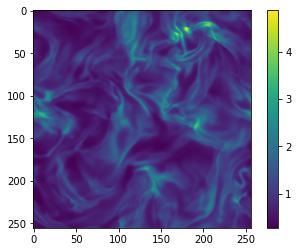

In [ ]:
plt.imshow(data[:,ld_one_d//2,:])
plt.colorbar()
plt.show()

We then convolve the data $\delta$ with the binned spherical harmonics $Y_{\ell m}(\hat{r}) \Theta(r, S)$ to yield $a_{\ell m}(S)$ cubes, where $S$ is the bin index. The Fourier transforms of the binned spherical harmonics are on disk, so we can perform the convolution by using the convolution theorem

$a_{\ell m}(S) = \mathcal{F}^{-1}\left[\mathcal{F}[\delta] \times \mathcal{F}[Y_{\ell m}(\hat{r}) \Theta(r, S)]\right]$

In [ ]:
#CONVOLUTION OF DATA AND SPH_KERNEL AT A GIVEN BIN
for l in range(0, ell_max+1, 1):
    for m in range(0,l+1, 1):
        for bin in range(0, nbins, 1):
            print("l, m, bin =", l, m, bin)
            #load ft of bsph_kernels
            bsph_kernel = np.load('YLMtilde_'+kernel_name+'_'+str(l)+'_'+str(m)+
                                '_bin_'+str(bin)+'.npy')
            conv = np.fft.ifftn(ft_data*bsph_kernel)
            del bsph_kernel
            np.save(save_name+'conv_data_kernel_'+kernel_name+'_'+str(l)+'_'+str(m)+
                  '_bin_'+str(bin)+'.npy', conv)
            del conv

l, m, bin = 0 0 0
l, m, bin = 0 0 1
l, m, bin = 0 0 2
l, m, bin = 0 0 3
l, m, bin = 1 0 0
l, m, bin = 1 0 1
l, m, bin = 1 0 2
l, m, bin = 1 0 3
l, m, bin = 1 1 0
l, m, bin = 1 1 1
l, m, bin = 1 1 2
l, m, bin = 1 1 3
l, m, bin = 2 0 0
l, m, bin = 2 0 1
l, m, bin = 2 0 2
l, m, bin = 2 0 3
l, m, bin = 2 1 0
l, m, bin = 2 1 1
l, m, bin = 2 1 2
l, m, bin = 2 1 3
l, m, bin = 2 2 0
l, m, bin = 2 2 1
l, m, bin = 2 2 2
l, m, bin = 2 2 3
l, m, bin = 3 0 0
l, m, bin = 3 0 1
l, m, bin = 3 0 2
l, m, bin = 3 0 3
l, m, bin = 3 1 0
l, m, bin = 3 1 1
l, m, bin = 3 1 2
l, m, bin = 3 1 3
l, m, bin = 3 2 0
l, m, bin = 3 2 1
l, m, bin = 3 2 2
l, m, bin = 3 2 3
l, m, bin = 3 3 0
l, m, bin = 3 3 1
l, m, bin = 3 3 2
l, m, bin = 3 3 3
l, m, bin = 4 0 0
l, m, bin = 4 0 1
l, m, bin = 4 0 2
l, m, bin = 4 0 3
l, m, bin = 4 1 0
l, m, bin = 4 1 1
l, m, bin = 4 1 2
l, m, bin = 4 1 3
l, m, bin = 4 2 0
l, m, bin = 4 2 1
l, m, bin = 4 2 2
l, m, bin = 4 2 3
l, m, bin = 4 3 0
l, m, bin = 4 3 1
l, m, bin = 4 3 2
l, m, bin 

We show slices of $a_{\ell m}(S)$ for $\ell=1$. Note that the convolutions for bins at larger radius pick out features on larger scales.

In [1]:
ell = 1
plt.figure(figsize=(10,4))
plt.subplot(2,nbins+1,1)
plt.imshow(data[:,ld_one_d//2,:])
plt.title('unconvolved δ')
plt.xticks([])
plt.yticks([])

for m in range(2):
    for bin in range(nbins):
        plt.subplot(2,nbins+1,m*(nbins+1)+bin+2)
        ylm_b = np.load(save_name+'conv_data_kernel_'+kernel_name+'_'+str(ell)+
                            '_'+str(m)+'_bin_'+str(bin)+'.npy').astype(np.complex128)
        plt.imshow(ylm_b[:,ld_one_d//2,:].real)
        if m == 0:
            plt.title('bin '+str(bin))
        if bin == 0:
            plt.ylabel('m='+str(m))
        plt.xticks([])
        plt.yticks([])
plt.suptitle('alm(S) for l=1', fontsize='x-large')
plt.show()

NameError: name 'plt' is not defined

To get the 3PCF coefficients, we must combine the $a_{\ell m}(S)$ and $\delta$:

$$\bar{\hat{\zeta}}_{\ell}(S_1,S_2) = \frac{1}{4\pi} \delta \sum_{m=-\ell}^{\ell} a_{\ell m}(S_1) a_{\ell m}^*(S_2)$$

Using the symmetry $Y_{\ell,-m}=(-1)^m Y_{\ell, m}^*$, we only need to sum over positive $m$:

$$\bar{\hat{\zeta}}_{\ell}(S_1,S_2) = \frac{1}{4\pi} \delta \left(a_{\ell 0}(S_1) a_{\ell 0}^*(S_2) + \sum_{m=1}^{\ell} \left[a_{\ell m}(S_1) a_{\ell m}^*(S_2) + a_{\ell m}^*(S_1) a_{\ell m}(S_2)\right] \right)$$

The figure below shows the components of the calculation of $\bar{\hat{\zeta}}_{\ell=1}(S_1=0,S_2=1)$.


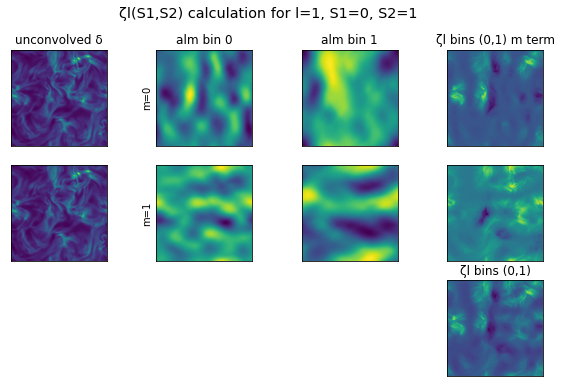

In [ ]:
ell = 1
bin1 = 0
bin2 = 1
plt.figure(figsize=(10,6))
cumulate = np.zeros_like(data, dtype=np.complex128)
for m in range(0,ell+1, 1):
    ylm_b1 = np.load(save_name+'conv_data_kernel_'+kernel_name+'_'+str(ell)+
                      '_'+str(m)+'_bin_'+str(bin1)+'.npy').astype(np.complex128)
    ylm_b2 = np.load(save_name+'conv_data_kernel_'+kernel_name+'_'+str(ell)+
                      '_'+str(m)+'_bin_'+str(bin2)+'.npy').astype(np.complex128)
    plt.subplot(ell+2,4,m*4+1)
    if m == 0:
        plt.title('unconvolved δ')
        plt.imshow(data[:,ld_one_d//2,:])
        plt.xticks([])
        plt.yticks([])
        plt.subplot(ell+2,4,m*4+2)
        plt.imshow(ylm_b1[:,ld_one_d//2,:].real)
    if m == 0:
        plt.title('alm bin '+str(bin1))
        plt.xticks([])
        plt.yticks([])
        plt.ylabel('m='+str(m))
        plt.subplot(ell+2,4,m*4+3)
        plt.imshow(ylm_b2[:,ld_one_d//2,:].real)
    if m == 0:
        plt.title('alm bin '+str(bin2))
        plt.xticks([])
        plt.yticks([])
        plt.subplot(ell+2,4,m*4+4)
    if m == 0:
        plt.title('ζl bins ('+str(bin1)+','+str(bin2)+') m term')
        plt.imshow((data*ylm_b1*ylm_b2.conjugate())[:,ld_one_d//2,:].real)
        cumulate += data*ylm_b1*ylm_b2.conjugate()
    if m > 1:
        cumulate += data*ylm_b1.conjugate()*ylm_b2
        plt.xticks([])
        plt.yticks([])

plt.subplot(ell+2,4,(ell+1)*4+4)
plt.title('ζl bins ('+str(bin1)+','+str(bin2)+')')
plt.imshow((cumulate)[:,ld_one_d//2,:].real)
plt.xticks([])
plt.yticks([])

plt.suptitle('ζl(S1,S2) calculation for l=1, S1=0, S2=1', fontsize='x-large')
plt.show()

Doing this calculation for all combinations of $l,m,S_1,S_2$ gives the 3PCF coefficients. Recall that $\zeta_{l}(S_1,S_2)$ is the projection of $\zeta(S_1,S_2,\cos \theta)$ onto the Legendre polynomials $P_\ell(\cos \theta)$, so including higher $\ell$ will capture more of the angular dependence of the 3PCF.

In [ ]:
#load alms (results of convolution at fixed ell and for all m, to combine).
zeta = np.zeros((ell_max + 1, nbins, nbins)) + 0j

for l in range(0, ell_max+1, 1):
    for bin1 in range(0, nbins, 1):
        for bin2 in range(0, bin1+1, 1):
            for m in range(0,l+1, 1):
            #load b1 and b2 at this m
            ylm_b1 = np.load(save_name+'conv_data_kernel_'+kernel_name+'_'+str(l)+
                             '_'+str(m)+'_bin_'+str(bin1)+'.npy').astype(np.complex128)
            ylm_b2 = np.load(save_name+'conv_data_kernel_'+kernel_name+'_'+str(l)+
                             '_'+str(m)+'_bin_'+str(bin2)+'.npy').astype(np.complex128)
            #form half of sum at that m.
            ylm_b1 *= ylm_b2.conjugate()
            del ylm_b2

            #average spatially now.
            ylm_avg = np.sum(data*ylm_b1)
            del ylm_b1
            # add in negative m: so basically we are computing m's in sum term by
            # term but with matching between + and - m.
            if m > 0:
                ylm_avg += ylm_avg.conjugate() 
            zeta[l, bin1, bin2] += ylm_avg #now accumulate so we get sum over m.

zeta *= 1./(4 * np.pi)

for l in range(0, ell_max+1, 1):
    for bin1 in range(0, nbins, 1):
        for bin2 in range(bin1+1, nbins, 1): #?? for bin2 in range(0, bin2<=bin1, 1):
            zeta[l, bin1, bin2] = zeta[l, bin2, bin1]

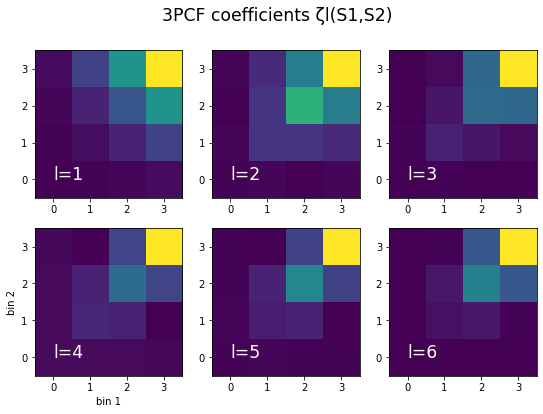

In [ ]:
plt.figure(figsize=(9,6))
for ell in range(0, ell_max+1, 1):
    plt.subplot(2,3,ell+1)
    plt.text(0,0,'l='+str(ell+1), c='white', fontsize='xx-large')
    plt.imshow(zeta[ell,:,:].real, origin='lower')
    plt.xticks(range(nbins))
    plt.yticks(range(nbins))
    if ell == 3:
        plt.xlabel('bin 1')
        plt.ylabel('bin 2')
plt.suptitle('3PCF coefficients ζl(S1,S2)', fontsize='xx-large')
plt.show()

$\bar{\zeta}_\ell(S_1,S_2)$ involves integrals over the voxels in bins $S_1$ and $S_2$, so it is useful to normalize by the product of the volumes of the two bins to estimate $\zeta_\ell(r_1,r_2)$, a quantity that is independent of the bin volume.

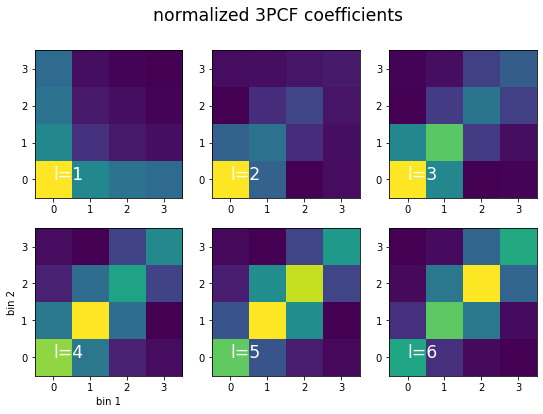

In [ ]:
binvolume = boundsandnumber[1,0:nbins]
normedzeta = zeta / (binvolume[:,None] * binvolume[None,:])

plt.figure(figsize=(9,6))
for ell in range(0, ell_max+1, 1):
    plt.subplot(2,3,ell+1)
    plt.text(0,0,'l='+str(ell+1), c='white', fontsize='xx-large')
    plt.imshow(normedzeta[ell,:,:].real, origin='lower')
    plt.xticks(range(nbins))
    plt.yticks(range(nbins))
    if ell == 3:
        plt.xlabel('bin 1')
        plt.ylabel('bin 2')
plt.suptitle('normalized 3PCF coefficients', fontsize='xx-large')
plt.show()

In [ ]:
np.save(save_name+'_'+kernel_name+'_zeta.npy',zeta)
call('rm '+save_name+'conv_data_kernel_'+kernel_name+'*', shell=True)